## Estimate the number of Richardson-Lucy deconvolution iterations

One issue with iterative deconvolution algorithms is the lack of clear stopping criteria. This example demonstrates how use image quality measures (PSNR, SSIM, and FRC) to track the progress of GPU-based RL deconvolution.

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread

from morphocell.cuda import ascupy, asnumpy
from morphocell.metrics import psnr, ssim, frc_resolution
from morphocell.preprocessing import deconv_iter_num_finder

### Load data and the PSF

A single 3D stack of Hoechst-stained astrocyte nuclei acquired with a Yokogawa CQ1 confocal microscope.
Theoretical 3D point spread function (PSF) was modeled using the Richards and Wolf algorithm from the PSFGenerator plugin for Fiji [2].
The image and the PSF can be [downloaded from Google Drive](../data/README.md).

In [2]:
scale_xy = 0.1625
scale_z = 0.3
voxel_sizes = (scale_z, scale_xy, scale_xy)

image = imread("../data/astr_vpa_hoechst.tif")
psf = imread("../data/astr_vpa_hoechst_psf_na095.tif")

image = ascupy(image)
psf = ascupy(psf)

Both image and the PSF have the same ZYX size of $30 \times 2160 \times 2560$.

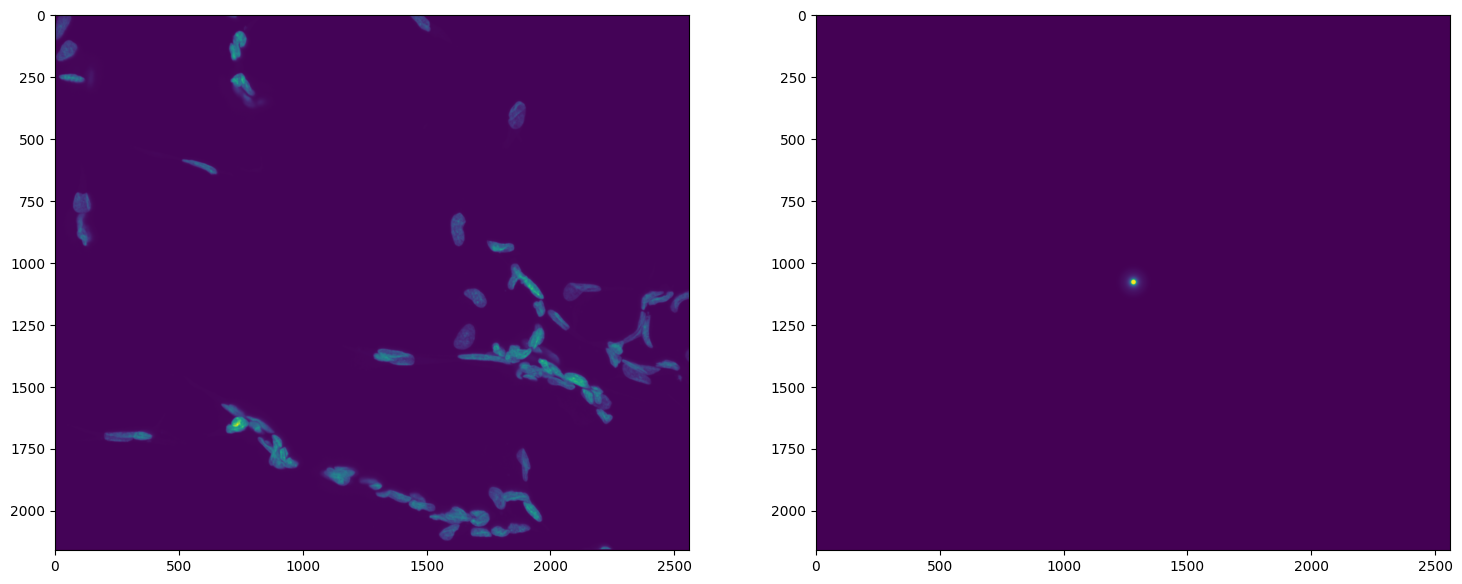

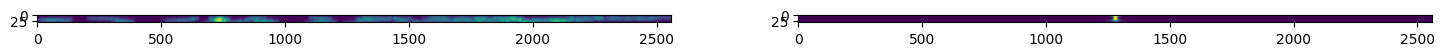

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(18, 18))
axes[0].imshow(asnumpy(image.max(0)))
axes[1].imshow(asnumpy(psf.max(0)), vmax=0.01)
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(18, 18))
axes[0].imshow(asnumpy(image.max(1)))
axes[1].imshow(asnumpy(psf.max(1)), vmax=0.01)
plt.show()

### Use PSNR improvement as a metric of decon quality

Here we demonstrate how to use peak signal-to-noise ratio (PSNR) as a criteria for determining the number of RL iterations.
MorphoCell will run RL on a GPU and at each iteration compare restored image with one from the previous iteration.
By default, images are padded in Z in 'reflect' mode on both sides up to 32 slices.

When provided threshold is reached, it returns the number of iterations and an object metric gains and intermediate images from all iterations.
Note that the RL will run for full `max_iter` iterations.
For better performance, metric computation stops after the treshold is reached, which can make the difference when metric computation is a bottleneck (e.g., for FRC).

We use fast GPU-based RL imaplementation from `flowdec` library [3].

In [4]:
psnr_thresh_iter, psnr_resolution = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=psnr,
    metric_kwargs={"scale_invariant": True},
    metric_threshold=80.0,
    max_iter=35,
    verbose=True,
    implementation="xpy",
    noncirc=False,
)

Iteration 1: improvement 49.92705565
Iteration 2: improvement 54.67385572
Iteration 3: improvement 57.66132929
Iteration 4: improvement 59.87482327
Iteration 5: improvement 61.71348642
Iteration 6: improvement 63.27595365
Iteration 7: improvement 64.63042994
Iteration 8: improvement 65.82847518
Iteration 9: improvement 66.90407262
Iteration 10: improvement 67.88084831
Iteration 11: improvement 68.77583052
Iteration 12: improvement 69.60179955
Iteration 13: improvement 70.36849445
Iteration 14: improvement 71.08358260
Iteration 15: improvement 71.76562704
Iteration 16: improvement 72.43258465
Iteration 17: improvement 73.09693501
Iteration 18: improvement 73.79620451
Iteration 19: improvement 74.46534744
Iteration 20: improvement 75.10658492
Iteration 21: improvement 75.72187687
Iteration 22: improvement 76.31286454
Iteration 23: improvement 76.88105466
Iteration 24: improvement 77.42779436
Iteration 25: improvement 77.95427616
Iteration 26: improvement 78.46159661
Iteration 27: improve

Now we can visualize the progress according to the provided metric.

PSNR doesn't quite plateau before reaching this threshold of 80 dB, which means it can be further increased, if needed.

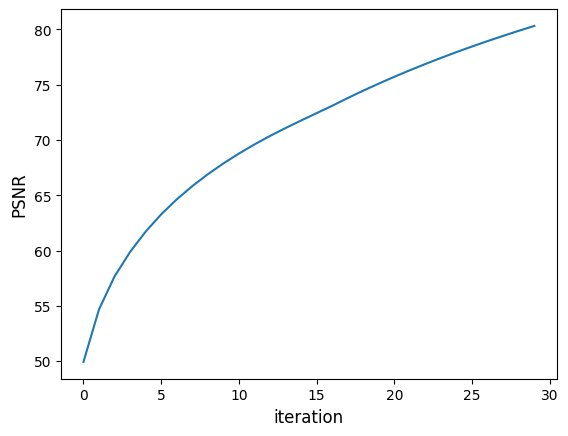

In [5]:
plt.plot([res["metric_gain"] for res in psnr_resolution[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("PSNR", fontsize=12)
plt.show()

And visualize original and restored images from the iteration at threshold next to each other.

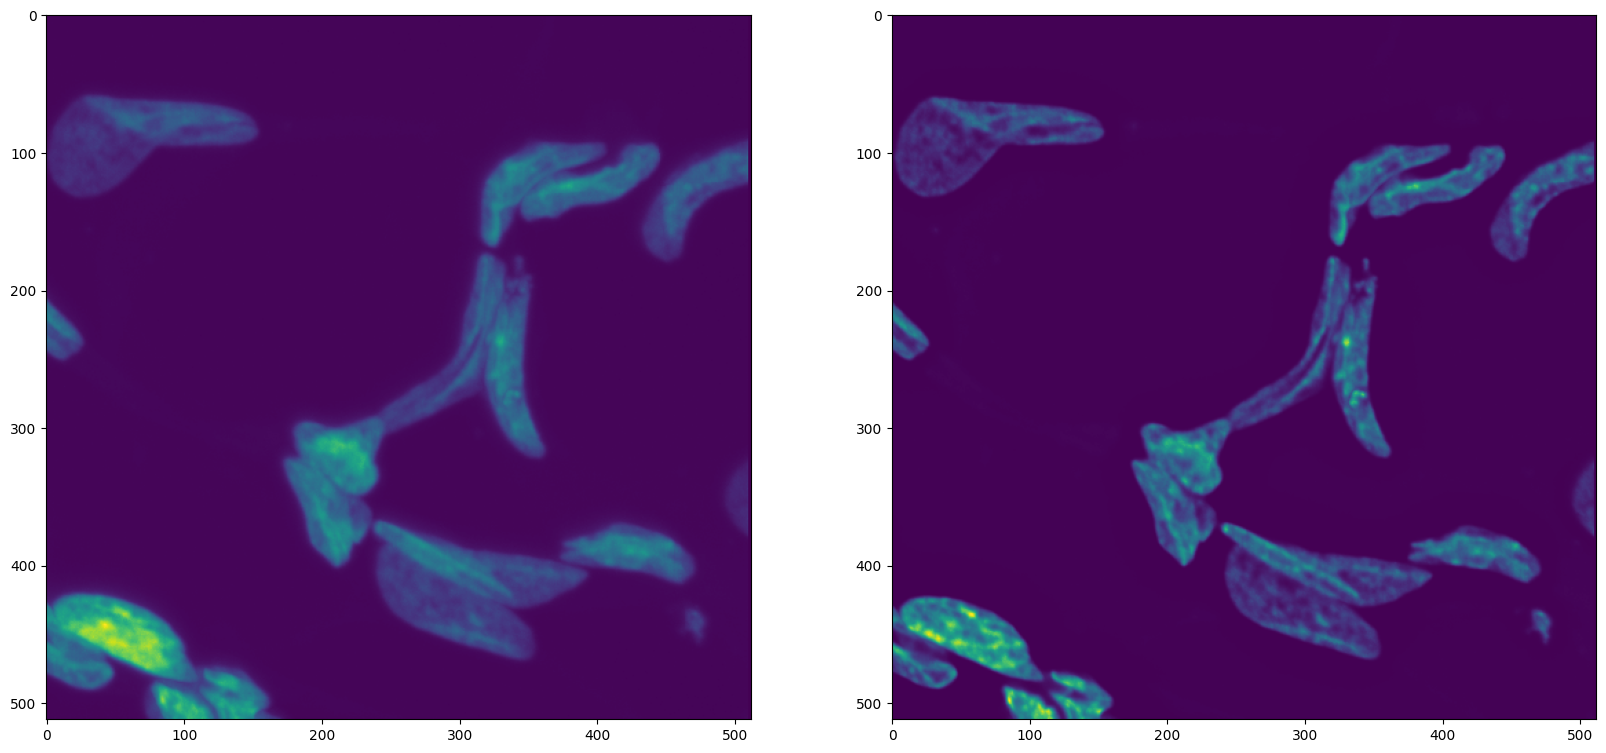

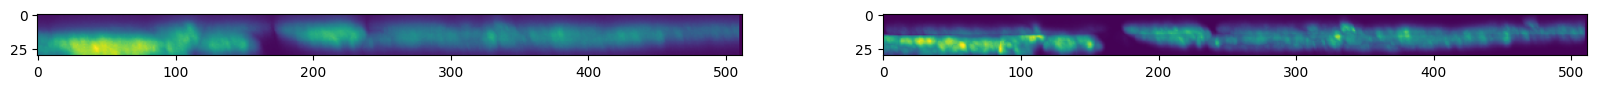

In [6]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)
deconv_image = psnr_resolution[psnr_thresh_iter]["iter_image"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(0)))
axes[1].imshow(asnumpy(deconv_image[patch].max(0)))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(1)))
axes[1].imshow(asnumpy(deconv_image[patch].max(1)))
plt.show()

### Use SSIM improvement as a metric of decon quality

Now, we repeat the process using structured similarity index (SSIM) as a progress metric instead.

In [7]:
ssim_thresh_iter, ssim_resolution = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=ssim,
    metric_kwargs={"scale_invariant": True},
    metric_threshold=0.99999,
    max_iter=35,
    verbose=True,
    implementation="xpy",
    noncirc=False,
)

Iteration 1: improvement 0.99025994
Iteration 2: improvement 0.99707708
Iteration 3: improvement 0.99860619
Iteration 4: improvement 0.99919281
Iteration 5: improvement 0.99948638
Iteration 6: improvement 0.99965207
Iteration 7: improvement 0.99975336
Iteration 8: improvement 0.99981899
Iteration 9: improvement 0.99986340
Iteration 10: improvement 0.99989447
Iteration 11: improvement 0.99991683
Iteration 12: improvement 0.99993331
Iteration 13: improvement 0.99994570
Iteration 14: improvement 0.99995519
Iteration 15: improvement 0.99996264
Iteration 16: improvement 0.99996862
Iteration 17: improvement 0.99997351
Iteration 18: improvement 0.99997765
Iteration 19: improvement 0.99998099
Iteration 20: improvement 0.99998371
Iteration 21: improvement 0.99998595
Iteration 22: improvement 0.99998780
Iteration 23: improvement 0.99998935
Iteration 24: improvement 0.99999064

Threshold 0.99999 reached at iteration 24 with improvement: 0.99999064.
Metric between original and restored images: 0.9

When visualized, SSIM shows reachin a plateau even before 10 iterations. This makes sense, because SSIM measures the perceived change in structural information, while PSNR estimates an absolute error.

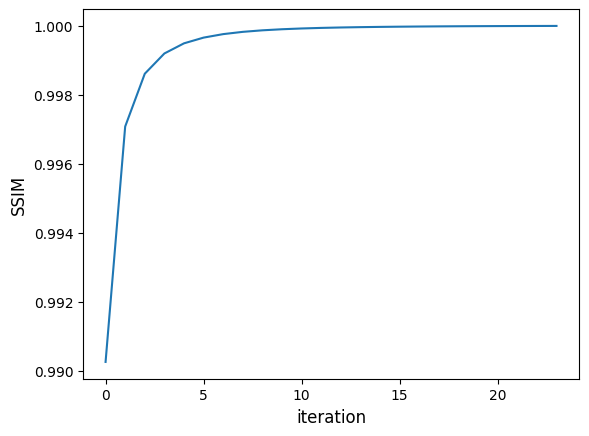

In [8]:
plt.plot([res["metric_gain"] for res in ssim_resolution[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.show()

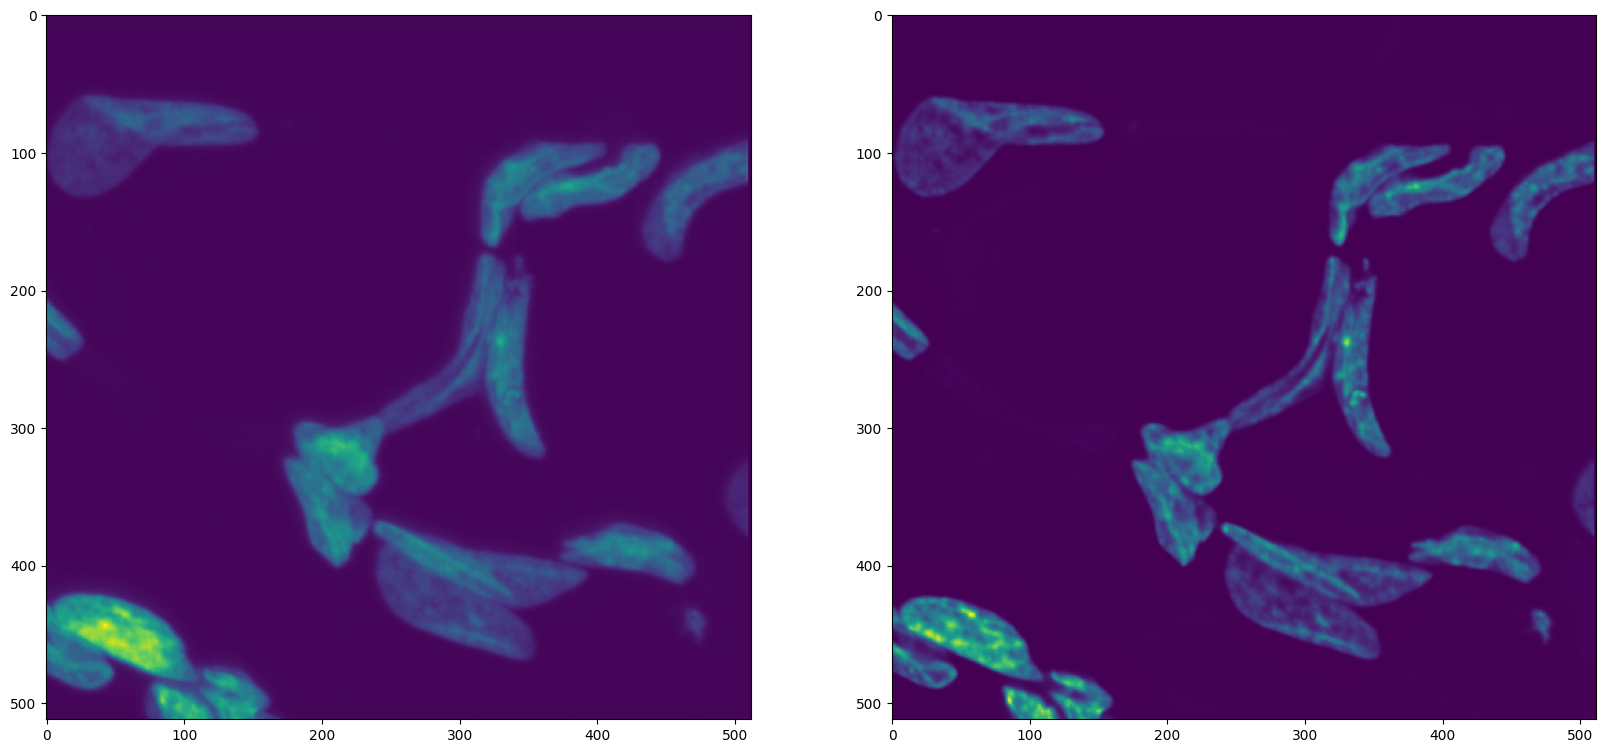

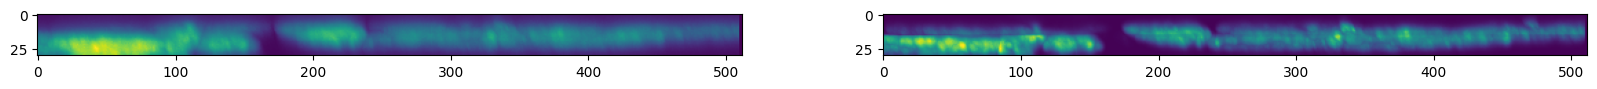

In [9]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)
deconv_image = ssim_resolution[ssim_thresh_iter]["iter_image"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(0)))
axes[1].imshow(asnumpy(deconv_image[patch].max(0)))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(1)))
axes[1].imshow(asnumpy(deconv_image[patch].max(1)))
plt.show()

### Use FRC-based resolution estimation improvement as a metric of decon quality

Finally, we employ Fourier Ring Correlation (FRC)-based image resolution estimation as a metric of RL progress morphocell provides FRC-based resolution metric, which requires a few parameters, for example, `bin_delta`, which sets the thickness of the ring for FRC calculation.

In [10]:
def frc_resolution_difference(image1, image2, bin_delta=3, spacing=1.0):
    """Calculate difference between FRC-based resulutions of two images."""
    if isinstance(spacing, (int, float)):
        spacing = (spacing, spacing)

    mid_z = image1.shape[0] // 2
    image1_res = frc_resolution(image1[mid_z], bin_delta=bin_delta, spacing=spacing)
    image2_res = frc_resolution(image2[mid_z], bin_delta=bin_delta, spacing=spacing)
    return (image2_res - image1_res) * 1000  # return diff in nm

In [11]:
frc_thresh_iter, frc_resolution_results = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=frc_resolution_difference,
    metric_kwargs={
        "bin_delta": 3,
        "spacing": scale_xy,
    },
    metric_threshold=-5.0,  # min improvement in nm/it
    max_iter=25,
    verbose=True,
    implementation="xpy",
    noncirc=False,
)

Iteration 1: improvement -16.21160077
Iteration 2: improvement -13.11631553
Iteration 3: improvement -12.95880673
Iteration 4: improvement -13.24632012
Iteration 5: improvement -14.09329343
Iteration 6: improvement -15.84340847
Iteration 7: improvement -17.86997311
Iteration 8: improvement -20.16583428
Iteration 9: improvement -18.77375143
Iteration 10: improvement -15.94778291
Iteration 11: improvement -13.91527001
Iteration 12: improvement -12.49536427
Iteration 13: improvement -11.92083571
Iteration 14: improvement -11.31877306
Iteration 15: improvement -10.69419252
Iteration 16: improvement -9.82694432
Iteration 17: improvement -8.72171091
Iteration 18: improvement -7.83033549
Iteration 19: improvement -6.93328248
Iteration 20: improvement -5.76491197
Iteration 21: improvement -4.98324722

Threshold -5.0 reached at iteration 21 with improvement: -4.98324722.
Metric between original and restored images: -262.63195474.



Visualization of FRC-based RL progress shows that the estimated number of iterations is similar to one obtained using PSNR, but most of the resolution gains have been made when the set threshold is reached.

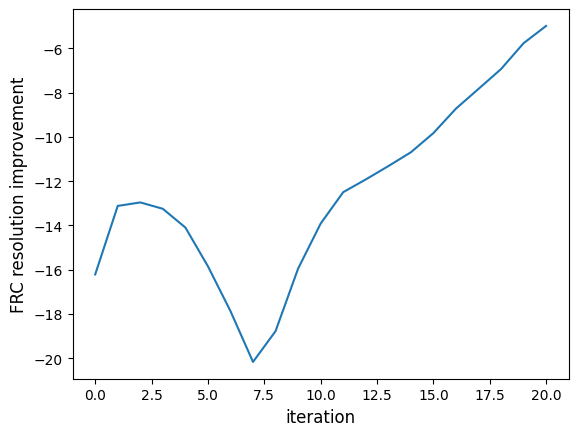

In [12]:
plt.plot([res["metric_gain"] for res in frc_resolution_results[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("FRC resolution improvement", fontsize=12)
plt.show()

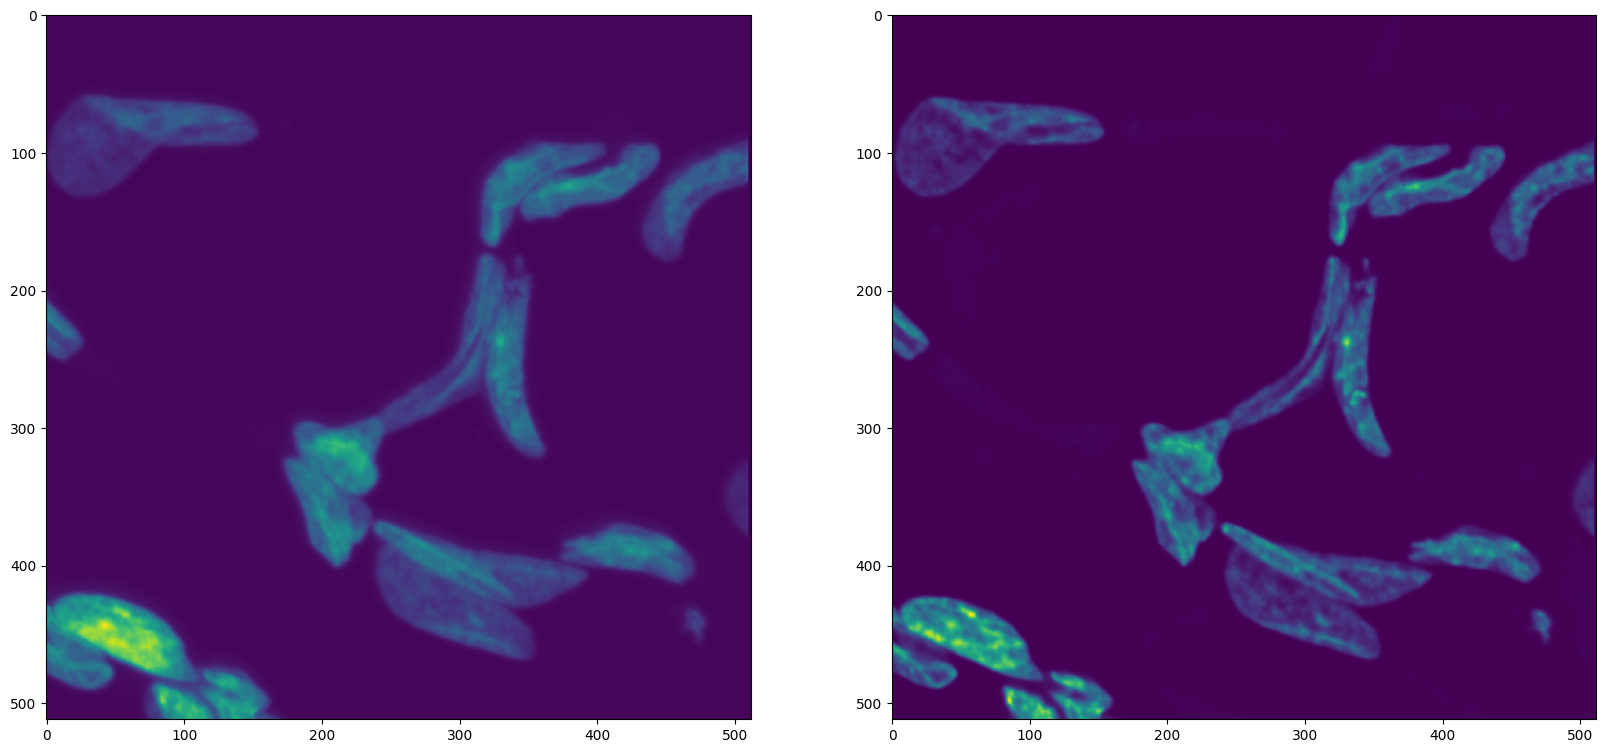

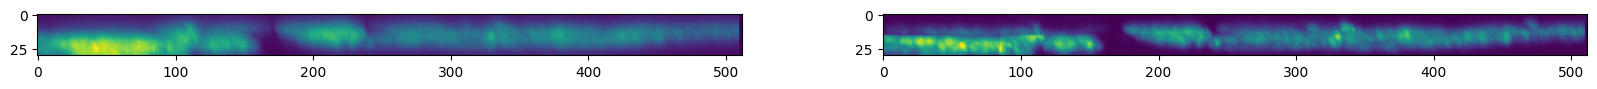

In [14]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)
deconv_image = frc_resolution_results[frc_thresh_iter]["iter_image"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(0)))
axes[1].imshow(asnumpy(deconv_image[patch].max(0)))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(1)))
axes[1].imshow(asnumpy(deconv_image[patch].max(1)))
plt.show()